In [1]:
import math
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib
matplotlib.__version__
import sys
print(sys.executable)
from plotly.colors import qualitative
import matplotlib.pyplot as plt

/home/seyma/anaconda3/envs/pytorch/bin/python


In [2]:
def read_edit(csv_dir):
    attribute_res = pd.read_csv(
        csv_dir,
        header=None,
        sep="\s+",
        names=["model_name", "pair_file", "pair_size", "Acc"],
    )
    attribute_res["attr_name"] = attribute_res.pair_file.apply(
        lambda x: x.split("from")[0]
    )  # subgroup based
    attribute_res["model_name"] = attribute_res.model_name.apply(
        lambda x: x.split("/")[-2]
    )
    attribute_res = attribute_res.drop(columns=["pair_file", "pair_size"])
    return attribute_res

In [3]:
attribute_res = read_edit(
    "../../test_assets/AttributePairs/setup2/attribute_rfw_test_results.log"
)
mean = attribute_res.groupby(["model_name", "attr_name"], observed=True).mean()
mean = mean.rename(columns={"Acc": "Mean_Acc"})

attribute_res = attribute_res.merge(
    mean, on=["model_name", "attr_name"], how="left", validate="m:1"
)
attribute_res = attribute_res.drop_duplicates(subset=["model_name", "attr_name"])

attribute_res = attribute_res[
    ~attribute_res.attr_name.isin(
        [
            "race_African_6000.csv",
            "race_Asian_6000.csv",
            "race_Indian_6000.csv",
            "race_Caucasian_6000.csv",
        ]
    )
]


for i, gg in attribute_res.groupby("model_name"):

    print(gg.model_name.unique(), gg.std() * 100)

    print("std:", np.std(gg.Acc.values, ddof=1) * 100)
    print("bias:", (1 - gg.Acc.values.min()) / (1 - gg.Acc.values.max()))
    attribute_res_excluded = gg[
        ~gg.attr_name.isin(["skintype_type1_6000.csv", "haircolor_red_6000.csv"])
    ]
    print("excluded std:", np.std(attribute_res_excluded.Acc.values, ddof=1) * 100)
    print(
        "excluded bias:",
        (1 - attribute_res_excluded.Acc.values.min())
        / (1 - attribute_res_excluded.Acc.values.max()),
    )

attribute_res.groupby("model_name").std() * 100

['setup2_model'] Acc         2.060341
Mean_Acc    2.060341
dtype: float64
std: 2.060340787807872
bias: 3.3129144300599966
excluded std: 1.7725220443370566
excluded bias: 3.0493020493020526


,Acc,Mean_Acc
model_name,,
setup2_model,2.060341,2.060341


In [4]:
#### Face Verification Table 1
#### it presents one attribute based results on 3000 positive 3000 negative
#### 21 attribute score + 4 african asian indian caucasian score + 2 metric bias and std 27 row, 2 column

attribute_res["Mean_Acc"] = attribute_res["Mean_Acc"].apply(
    lambda x: "{:.2f}".format(x * 100)
)

attribute_res["attr_name"] = attribute_res["attr_name"].apply(
    lambda x: " ".join(x.split("_")[0:2])
)
attribute_res["attr_name"] = attribute_res["attr_name"].str.replace("skintype", "")
attribute_res["attr_name"] = attribute_res["attr_name"].str.replace(
    "haircolor", "Hair "
)
attribute_res["attr_name"] = attribute_res["attr_name"].str.replace("hairtype", "Hair ")
attribute_res["attr_name"] = attribute_res["attr_name"].str.replace("lips", "Lips ")
attribute_res["attr_name"] = attribute_res["attr_name"].str.replace("eye", "eye ")
attribute_res["attr_name"] = attribute_res["attr_name"].str.replace("nose", "nose ")
attribute_res["attr_name"] = attribute_res["attr_name"].str.title()
attribute_res["attr_name"] = attribute_res["attr_name"].apply(
    lambda x: " ".join(x.split(" ")[::-1])
)
attribute_res = attribute_res[["model_name", "attr_name", "Mean_Acc"]]


attribute_res = attribute_res.sort_values(
    by=["model_name", "attr_name"], ascending=False
)


print(attribute_res.columns)
attribute_res = attribute_res.drop(columns=['model_name'])
attribute_res.columns = ["Attribute", "Setup 2 Accuracy (%)"]
attribute_res = attribute_res.sort_values(by=["Setup 2 Accuracy (%)"], ascending=False)

attribute_res.head()

Index(['model_name', 'attr_name', 'Mean_Acc'], dtype='object')


,Attribute,Setup 2 Accuracy (%)
6,Red Hair,96.83
3,Blonde Hair,96.63
20,Type2,95.83
5,Gray Hair,95.83
7,Bald Hair,95.70


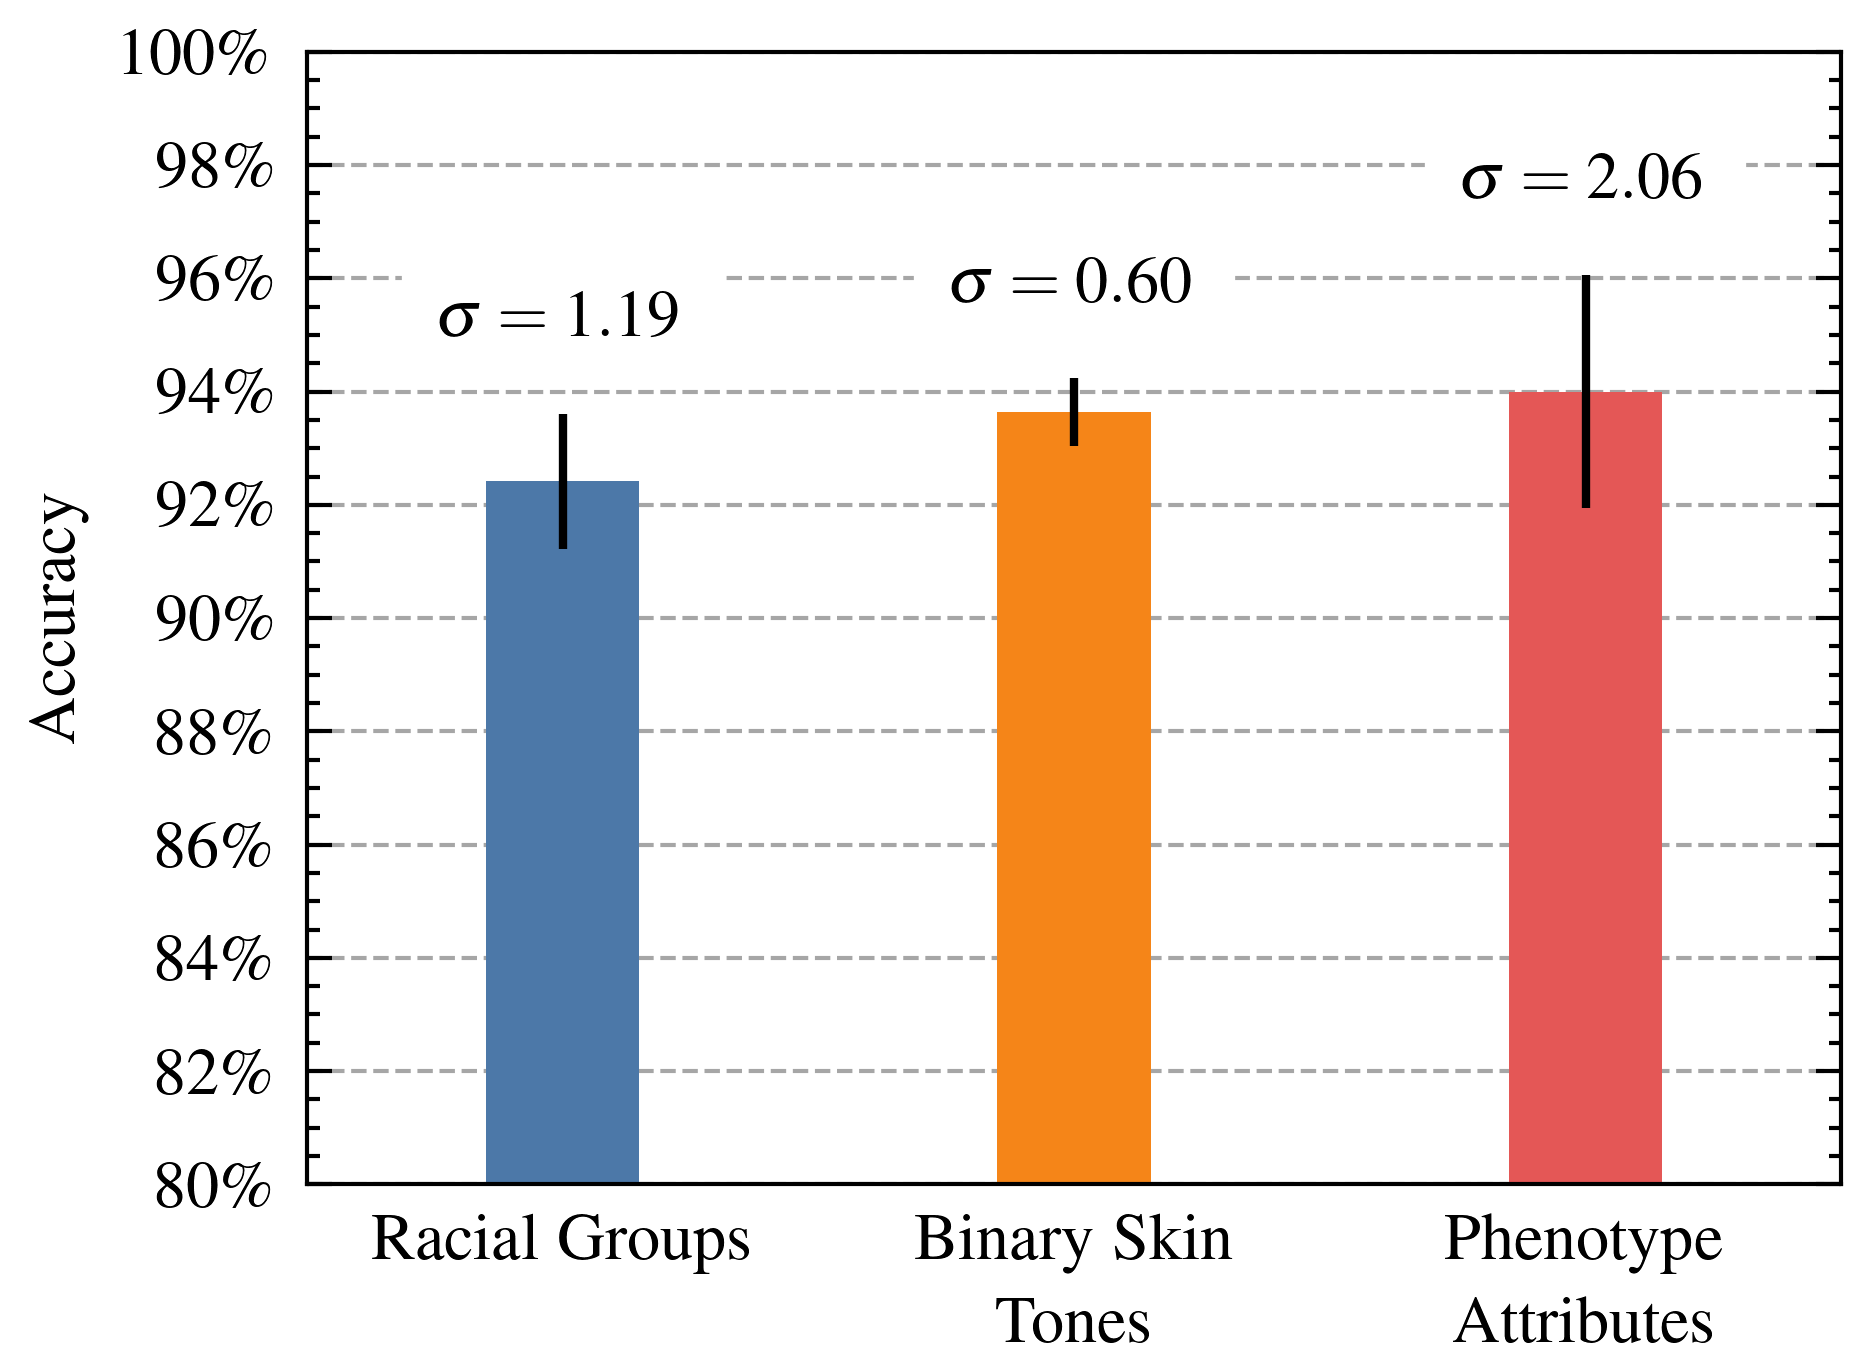

In [5]:
plt.style.use(["science", "ieee", "vibrant", "grid"])
plt.rcParams["grid.alpha"] = 0.35
plt.rcParams["grid.color"] = "#000000"
plt.rcParams["xtick.color"] = "#000000"

buptstd = np.asarray([94.18, 92.82, 91.2391, 91.42])
skin_acc = np.array(
    [
        attribute_res[attribute_res.Attribute.isin(["Type1 ", "Type2 ", "Type3 "])][
            "Setup 2 Accuracy (%)"
        ]
        .astype(float)
        .mean(),
        attribute_res[attribute_res.Attribute.isin(["Type4 ", "Type5 ", "Type6 "])][
            "Setup 2 Accuracy (%)"
        ]
        .astype(float)
        .mean(),
    ]
)


colors = qualitative.T10


def err_bars(ax, distributions):
    hbar = ax.bar(
        range(3),
        [d.mean() for d in distributions.values()],
        width=0.3,
        yerr=[d.std() for d in distributions.values()],
        label=list(distributions.keys()),
        color=[colors[i] for i in range(3)],
    )
    ax.bar_label(
        hbar,
        labels=[f"$\sigma={d.std():.2f}$" for d in distributions.values()],
        backgroundcolor="w",
        padding=7.5,
    )


fig, ax = plt.subplots()
ax.autoscale(tight=True)
# pparam = dict(xlabel="Groupings", ylabel="Accuracy")
pparam = dict(ylabel="Accuracy")

ax.set(**pparam)

datasets = {
    "Racial Groups": np.asarray([94.18, 92.82, 91.2391, 91.42]),
    r"\begin{center}Binary Skin\\Tones\end{center}": skin_acc,
    r"\begin{center}Phenotype\\Attributes\end{center}": attribute_res[
        "Setup 2 Accuracy (%)"
    ].astype(float),
}
err_bars(ax, datasets)
ax.set_xticks(range(3))
ax.set_xticklabels(datasets.keys())
ax.tick_params(which="both", axis="x", length=0)
ax.set_yticks(range(80, 101, 2))
ax.set_yticklabels([f"${100*y:.0f}\%$" for y in np.arange(0.8, 1.01, 0.02)])
ax.grid(axis="x", color="1")
# ax.grid(axis='y',color='0.7')
ax.set_axisbelow(True)
plt.ylim(80, 100)
plt.xlim(-0.5, 2.5)
# plt.show()

fig.savefig("../grouping-std.pdf", dpi=300)
fig.savefig("../grouping-std.png", dpi=300)